In [1]:
from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid

device = "cuda" if torch.cuda.is_available() else "cpu"
data_path = "data/mnist"

train_dataset = datasets.MNIST(
    root=data_path, train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.MNIST(
    root=data_path, train=False, transform=transforms.ToTensor(), download=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=64, shuffle=False
)

In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.d1 = nn.Linear(x_dim, h_dim1)
        self.relu1 = nn.ReLU()
        self.d2 = nn.Linear(h_dim1, h_dim2)
        self.relu2 = nn.ReLU()

        self.d31 = nn.Linear(h_dim2, z_dim)
        self.d32 = nn.Linear(h_dim2, z_dim)

        self.d4 = nn.Linear(z_dim, h_dim2)
        self.relu4 = nn.ReLU()
        self.d5 = nn.Linear(h_dim2, h_dim1)
        self.relu5 = nn.ReLU()
        self.d6 = nn.Linear(h_dim1, x_dim)
        self.sigmoid = nn.Sigmoid()

    def encoder(self, x):
        h = self.relu1(self.d1(x))
        h = self.relu2(self.d2(h))
        return self.d31(h), self.d32(h)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)

    def decoder(self, z):
        h = self.relu4(self.d4(z))
        h = self.relu5(self.d5(h))
        return self.sigmoid(self.d6(h))

    def forward(self, x):
        mean, log_var = self.encoder(x.flatten(1, -1))
        z = self.reparameterize(mean, log_var)
        return self.decoder(z), mean, log_var

In [3]:
from torchinfo import summary

model = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50)
summary(model, (1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 784]                  --
├─Linear: 1-1                            [1, 512]                  401,920
├─ReLU: 1-2                              [1, 512]                  --
├─Linear: 1-3                            [1, 256]                  131,328
├─ReLU: 1-4                              [1, 256]                  --
├─Linear: 1-5                            [1, 50]                   12,850
├─Linear: 1-6                            [1, 50]                   12,850
├─Linear: 1-7                            [1, 256]                  13,056
├─ReLU: 1-8                              [1, 256]                  --
├─Linear: 1-9                            [1, 512]                  131,584
├─ReLU: 1-10                             [1, 512]                  --
├─Linear: 1-11                           [1, 784]                  402,192
├─Sigmoid: 1-12                          [1, 784]    

In [4]:
def train_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()


@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()


def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

In [5]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)

EPOCH: 1.000  train_log_var: -0.158  val_kld: 448.514  train_kld: 262.710  train_loss: 2914.657  val_loss: 2341.472  val_mean: -0.009  train_mean: -0.001  val_log_var: -0.276  val_recon: 1892.957  train_recon: 2651.947  (7.27s - 65.46s remaining)


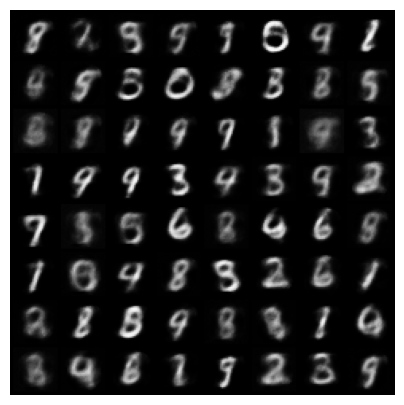

EPOCH: 2.000  train_log_var: -0.299  val_kld: 490.196  train_kld: 492.602  train_loss: 2212.799  val_loss: 2104.063  val_mean: -0.003  train_mean: -0.000  val_log_var: -0.295  val_recon: 1613.867  train_recon: 1720.197  (15.74s - 62.95s remaining)


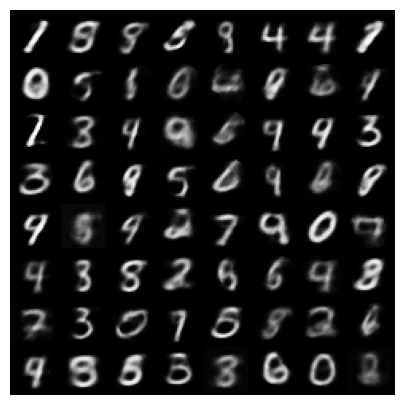

EPOCH: 3.000  train_log_var: -0.332  val_kld: 555.724  train_kld: 539.433  train_loss: 2077.329  val_loss: 2012.803  val_mean: 0.003  train_mean: 0.000  val_log_var: -0.338  val_recon: 1457.079  train_recon: 1537.896  (23.53s - 54.90s remaining)


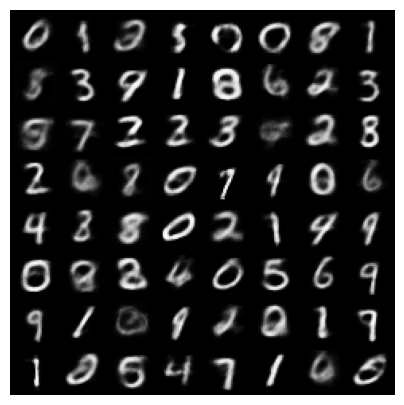

EPOCH: 4.000  train_log_var: -0.350  val_kld: 567.174  train_kld: 567.311  train_loss: 2002.459  val_loss: 1957.118  val_mean: -0.005  train_mean: -0.000  val_log_var: -0.354  val_recon: 1389.944  train_recon: 1435.148  (31.57s - 47.35s remaining)


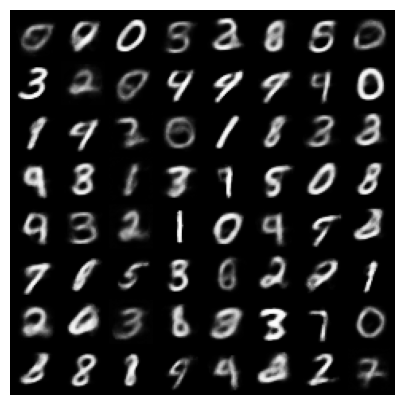

EPOCH: 5.000  train_log_var: -0.363  val_kld: 579.340  train_kld: 585.479  train_loss: 1957.612  val_loss: 1934.085  val_mean: 0.001  train_mean: -0.000  val_log_var: -0.361  val_recon: 1354.745  train_recon: 1372.134  (39.79s - 39.79s remaining)


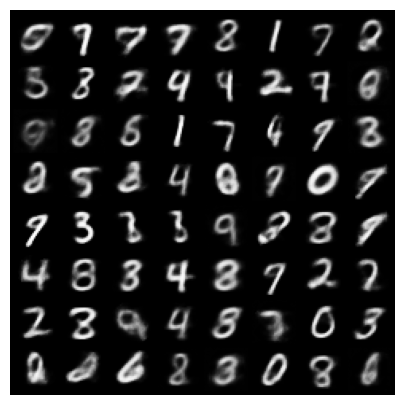

EPOCH: 6.000  train_log_var: -0.371  val_kld: 604.072  train_kld: 596.618  train_loss: 1929.026  val_loss: 1898.024  val_mean: -0.001  train_mean: 0.000  val_log_var: -0.377  val_recon: 1293.952  train_recon: 1332.408  (47.98s - 31.98s remaining)


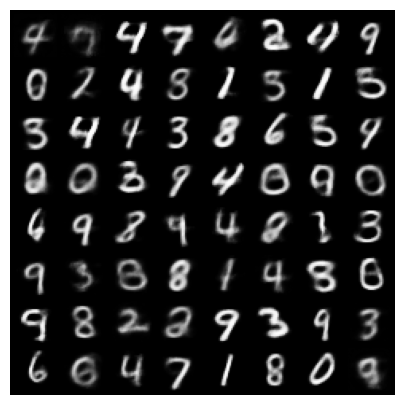

EPOCH: 7.000  train_log_var: -0.377  val_kld: 614.447  train_kld: 606.590  train_loss: 1904.740  val_loss: 1881.174  val_mean: -0.001  train_mean: -0.000  val_log_var: -0.379  val_recon: 1266.727  train_recon: 1298.149  (56.54s - 24.23s remaining)


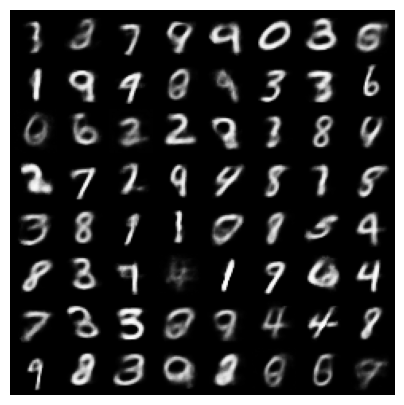

EPOCH: 8.000  train_log_var: -0.382  val_kld: 621.601  train_kld: 613.248  train_loss: 1884.956  val_loss: 1869.623  val_mean: -0.001  train_mean: 0.000  val_log_var: -0.390  val_recon: 1248.021  train_recon: 1271.708  (64.62s - 16.15s remaining)


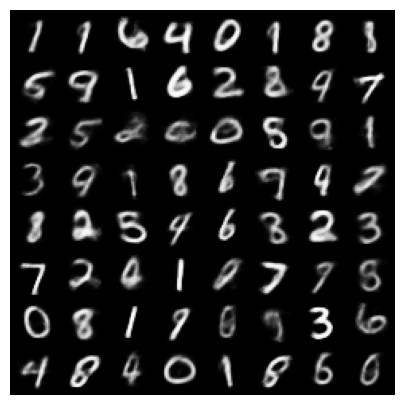

EPOCH: 9.000  train_log_var: -0.387  val_kld: 620.371  train_kld: 620.294  train_loss: 1870.413  val_loss: 1858.146  val_mean: -0.006  train_mean: -0.000  val_log_var: -0.384  val_recon: 1237.775  train_recon: 1250.119  (72.24s - 8.03s remaining)


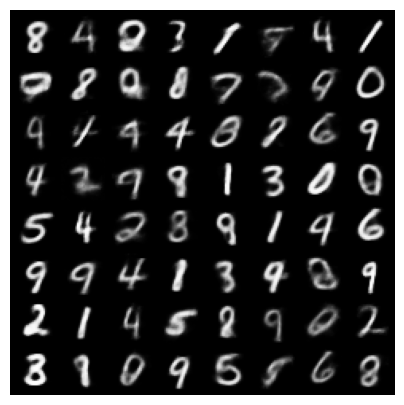

EPOCH: 10.000  train_log_var: -0.389  val_kld: 629.610  train_kld: 625.202  train_loss: 1856.699  val_loss: 1839.204  val_mean: -0.004  train_mean: -0.000  val_log_var: -0.393  val_recon: 1209.594  train_recon: 1231.497  (80.43s - 0.00s remaining)


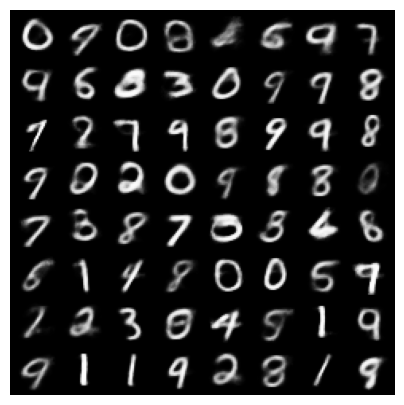

In [6]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(
            data, vae, optimizer, loss_function
        )
        pos = epoch + (1 + batch_idx) / N
        log.record(
            pos,
            train_loss=loss,
            train_kld=kld,
            train_recon=recon,
            train_log_var=log_var,
            train_mean=mean,
            end="\r",
        )

    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1 + batch_idx) / N
        log.record(
            pos,
            val_loss=loss,
            val_kld=kld,
            val_recon=recon,
            val_log_var=log_var,
            val_mean=mean,
            end="\r",
        )

    log.report_avgs(epoch + 1)
    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1, 2, 0)
        show(images)

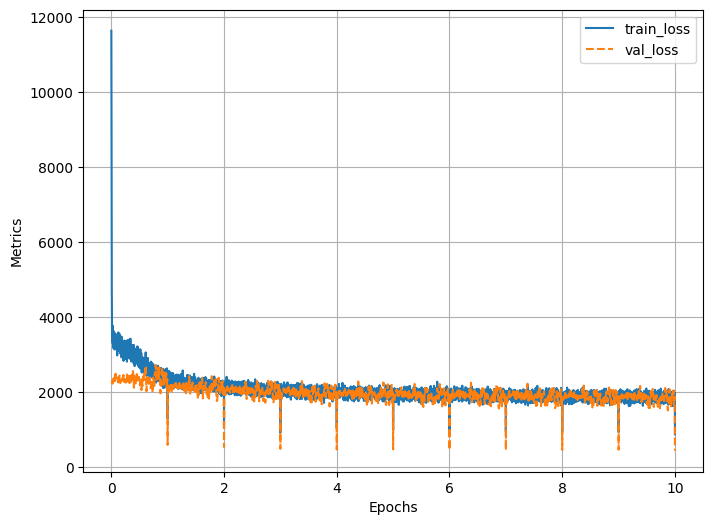

In [7]:
log.plot(["train_loss", "val_loss"])

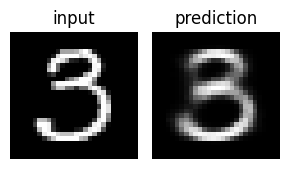

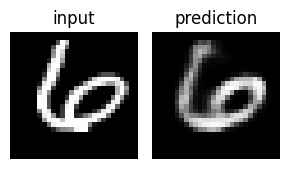

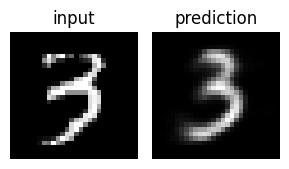

In [8]:
for _ in range(3):
    ix = np.random.randint(len(test_dataset))
    im, _ = test_dataset[ix]
    # print(im.shape)
    _im = vae(im.to(device="cuda"))[0]
    fig, ax = plt.subplots(1, 2, figsize=(3, 3))
    show(im[0], ax=ax[0], title="input")
    show(
        _im.to(device="cpu").detach().numpy().reshape((28, 28)),
        ax=ax[1],
        title="prediction",
    )
    plt.tight_layout()
    plt.show()